# Data Ingestion and EDA

#### Bank Statement from Jan 2022 to Oct 2023 but its in raw pdf (as shown below)

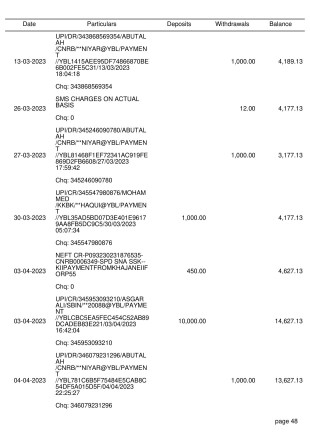

#### Hence we use a python library to be able to work with it

In [3]:
from pdfquery import PDFQuery
pdf = PDFQuery('bank.pdf')
pdf.load()
#convert the pdf to XML and save
pdf.tree.write('bank.xml', pretty_print = True)

#### Scraping the file using bs4's BeatifulSoup

In [4]:
from bs4 import BeautifulSoup
with open('bank.xml', 'r') as file:
    soup = BeautifulSoup(file, 'lxml')

In [5]:
pages = soup.find('pdfxml').find_all('ltpage')

#### pages is a list of all page elements
#### there is lttextlinehorizontal in that all element
Let's first take out transactions from it

In [21]:
transactions = []
for i in pages:
    for j in range(len(i.find_all('lttextlinehorizontal'))): 
        s = i.find_all('lttextlinehorizontal')[j].text.strip()
        if s.replace(',','').replace('.','').isnumeric()  : # all data containing . and is 
            transactions.append(float(s.replace(',','')))

##### The code below removes unrelated values, adds misplaced values and cleanify the data

In [105]:
# transactions.pop(9) # Removed a data 10506 which was bank code
# transactions.pop(len(transactions)-1) # It was closing balance
# transactions.pop(329) #--Why this 2 is occuring when there is no relevent data in pdf some scraping issue
# transactions.insert(613,5000) # some -ve value has been ignored (it was incomplete transaction)
# transactions.insert(624,transactions[625]) #-- misplaced value
# transactions.pop(626)  #-- removing misplaced value
# transactions.insert(801, transactions[799]) -ve value has been ignored (it was incomplete transaction)
# transactions.pop(826) #-- 7.09 misplaced i.e., position 827 value was placed at pos 826 
# transactions.insert(827, transactions[825])
# transactions.pop(865) #- A data which is not a transaction was included hence removed

In [249]:
len(transactions)

1019

#### Getting to know whether its a debit or credit

In [113]:
doc = []
for i in range(len(transactions)-2):
    if i%2==0 :
        if round(transactions[i] + transactions[i+1],2) == round(transactions[i+2],2):
            doc.append('Cr')
        elif round(transactions[i] - transactions[i+1],2) == round(transactions[i+2],2):
            doc.append('Db')
        else : 
            doc.append(f'Unknown')
            doc.append(i)

In [251]:
try:
    doc.index('Unknown')
    print('some inaccuracy in transactions')
except:
    print('Transactions are accurate')

Transactions are accurate


In [252]:
doc[6:10]

['Db', 'Db', 'Cr', 'Cr']

In [253]:
len(doc)

509

In [123]:
balance = []
for i in range(len(transactions)):
    if i%2==0:
        balance.append(transactions[i])

# balance = transactions[::2]  # Or this its same

In [255]:
len(balance)

510

In [138]:
# balance.pop(0) #-- to align balance and doc 

In [139]:
len(balance)

509

#### Now consider the amounts from transactions (i.e., at odd index)

In [144]:
amounts = transactions[1::2] 

In [146]:
len(amounts)

509

#### Now try to extract 509 actual dates

In [188]:
dates = []
checknum = lambda x : (x[0]+x[1]+x[2]).isnumeric() # we have splitted text we get by "-"
conc = lambda x: x[0]+ '-' + x[1] + '-' + x[2]    # hence we check and concat 
for i in pages:
    for j in range(len(i.find_all('lttextboxhorizontal'))): 
        s = i.find_all('lttextboxhorizontal')[j].text.strip()
        el_s = s.split('-')
        if len(el_s)==3 and checknum(el_s):
            dates.append(conc(el_s))

In [189]:
len(dates)

509

#### Mode of payment 

In [190]:
for i in pages:
    for j in range(len(i.find_all('lttextboxhorizontal'))): 
        s = i.find_all('lttextboxhorizontal')[j].text.strip()
        print(s)

Statement for A/c XXXXXXXXXX6372 between 01-Jan-2022 and 07-Oct-2023
Opening Balance
4,83,292.87
10,000.00
4,73,292.87
10,000.00
4,63,292.87
930.00
4,62,362.87
2,000.00
4,60,362.87
page 1
01-01-2022
ATM CASH-A0506001- CANARABANKRAMDURGKAIN- 01/01/22 12:18:34/7543
Chq: 3280
01-01-2022
ATM CASH-A0506001- CANARABANKRAMDURGKAIN- 01/01/22 12:20:20/7543
UPI/DR/200287975521/AYUB RAJE/UBIN/**04082@YBL/PAY MENT //YBL6147B74B58AC4C16A43C 4CED7DC5F020/02/01/2022 16:10:57
Chq: 200287975521
UPI/DR/200790560804/ABUTAL AH /CNRB/**NIYAR@YBL/PAYMEN
/YBLAC9D6F1132D34949A3E9 2FF7A1FC2258/07/01/2022 23:01:07
Chq: 200790560804
Chq: 3282
02-01-2022
07-01-2022
Customer Id
XXXXXXX56
Name
Phone
MANIYAR DADAKHALANDA
+919845248216
A d d r e s s A S S T T E A C H E R A T G M K SCHOOL SUREBAN RAMADURG KARNATAKA
Branch Code
10506
Branch Name
RAMADURG
IFSC Code
CNRB0010506
Address 591 123 RAMDURG KARNATAKA
BELGAUM ROAD RAMADURG-
Date
Particulars
Deposits
Withdrawals
Balance
1,000.00
4,59,362.87
1,800.00
4,57,562.87


#### The order is missing hence follow the below steps
Now I have cropped pdf at **_sejda.com/crop-pdf_** and converted it to jpg using **_smallpdf.com_**

![0048[1].jpg](attachment:d450960b-89c4-4ba6-9681-916bac43fd7d.jpg)
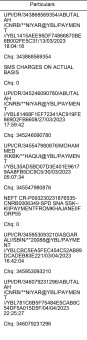

In [285]:
from PyPDF2 import PdfReader
reader = PdfReader("bankcropped.pdf")

In [289]:
transactions_per_page = []
for i in range(74):
    page = reader.pages[i]
    size = len(page.extract_text().split('Chq:')) -1
    transactions_per_page.append(size)

In [297]:
sum(transactions_per_page)

509

In [247]:
import cv2
import pytesseract 
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [306]:
page_details = []
for i in range(1,75):
    print(f'------------------------------{i}-------------------------------------')
    if i <10 : img = cv2.imread(f"imgbank/000{i}.jpg")
    else : img = cv2.imread(f"imgbank/00{i}.jpg")
    page_detail = pytesseract.image_to_string(img).replace('Chq;','Chq').replace('Cha:','Chq:')
    page_details.append(page_detail)

------------------------------1-------------------------------------
------------------------------2-------------------------------------
------------------------------3-------------------------------------
------------------------------4-------------------------------------
------------------------------5-------------------------------------
------------------------------6-------------------------------------
------------------------------7-------------------------------------
------------------------------8-------------------------------------
------------------------------9-------------------------------------
------------------------------10-------------------------------------
------------------------------11-------------------------------------
------------------------------12-------------------------------------
------------------------------13-------------------------------------
------------------------------14-------------------------------------
-----------------------------

In [311]:
page_content = []
for i in page_details:
    content = i.split('Chq:')
    page_content.append(content)

In [317]:
transactions_per_page2 = []
for i in range(74):
    size = len(page_content[i])-1
    transactions_per_page2.append(size)

In [318]:
sum(transactions_per_page2)

508

##### A missing transaction

In [326]:
# 1 transaction is missing so we try to find it out
for i in range(74):
    if transactions_per_page[i] != transactions_per_page2[i]:
        print(i)

70


In [327]:
transactions_per_page[70]

7

In [328]:
transactions_per_page2[70]

6

The below lines of code has been implemented to fix this issue

In [104]:
# page_content[70][2]=page_content[70][2].replace('Chg:','Chq:')
# page_content[70][2].split('Chq:')
# page_content[70].insert(2,page_content[70][2].split('Chq:'))
# add_it = page_content[70][2].copy()
# add_it
# page_content[70].insert(3,add_it[1])
# page_content[70]

In [367]:
transactions_per_page2 = []
for i in range(74):
    size = len(page_content[i])-1
    transactions_per_page2.append(size)

In [366]:
sum(transactions_per_page2)

509

In [378]:
page_csv = []
for i in page_content:
    page_csv.extend(i[:-1])

In [379]:
len(page_csv)

509

#### Now, we have description of each and every transaction accordingly

In [1]:
import pandas as pd

In [ ]:
df = pd.Series(page_csv)
df.to_csv('particulars.csv')

In [2]:
df = pd.read_csv('particulars.csv')

In [3]:
df.drop('Unnamed: 0', axis= 1, inplace=True)

In [11]:
modes = []
for i in range(509):
    if 'UPI' in df.values[i][0]:
        modes.append('UPI')
    elif 'ATM' in df.values[i][0]:
        modes.append('ATM')
    elif 'NEFT' in df.values[i][0]:
        modes.append('NEFT')
    elif 'ECS' in df.values[i][0]:
        modes.append('ECS')
    elif 'CHQ' in df.values[i][0] or 'CHEQUE' in df.values[i][0]:
        modes.append('CHEQUE')
    elif 'DEBIT CARD ANNUAL' in df.values[i][0]:
        modes.append('DEBIT CARD ANNUAL')
    elif 'SBINT' in df.values[i][0]:
        modes.append('SBINT')
    elif 'SMS' in df.values[i][0]:
        modes.append('SMS CHARGES')
    elif 'IMPS' in df.values[i][0]:
        modes.append('IMPS')
    elif 'TRANS UNION CIBIL' in df.values[i][0] or 'EXPERIAN CONSUMER' in df.values[i][0] :
        modes.append('STOCK CHRG')
    elif 'FUNDS TRANSFER DEBIT' in df.values[i][0]:
        modes.append('FUNDS TRANSFER DEBIT')
    elif 'BY CLG:CHN' in df.values[i][0]:
        modes.append('CHEQUE')
    elif 'IB ITG' in df.values[i][0]:
        modes.append('UNKNOWN')
    else: modes.append('OTHER')

In [12]:
len(modes)

509

#### Now we try to extract names from it

In [71]:
upi_transactions = pd.Series(modes)[pd.Series(modes) == 'UPI']

In [75]:
upi_transactions.size

370

In [68]:
names=[]
for i in range(370):
    name = df.iloc[upi_transactions].values[i][0].split('/')[3].replace('\n','')[:9]
    names.append(name)

In [69]:
len(names)

370

In [70]:
names  # Below are all names

['AYUBRAJE',
 'ABUTALAH',
 'AGRAWALB',
 'GOASELEC',
 'GOASELEC',
 'AGRAWALB',
 'NAFEESAB',
 'NAFEESAB',
 'MAHAMMADH',
 'PHONEPE',
 'PHONEPE',
 'FLIPKART',
 'BUDESAHEB',
 'FLIPKART',
 'AYUBRAJE',
 'STATEBAN',
 'BUDESAHEB',
 'PHONEPE',
 'PHONEPE',
 'ABUTALAH',
 'BUDESAHEB',
 'ABDULHAME',
 'NAFEESAB',
 'ABUTALAH',
 'AYUBRAJE',
 'SANGALLI',
 'SANGALLI',
 'ABUTALAH',
 'PHONEPE',
 'SANGALLI',
 'NAFEESAB',
 'NAFEESAB',
 'ABUTALAH',
 'SANGALLI',
 'PHONEPE',
 'ABUTALAH',
 'ABUTALAH',
 'SANGALLI',
 'KIRNAKUMA',
 'ABUTALAH',
 'ABUTALAH',
 'ABUTALAH',
 'AYUBRAJE',
 'SANGALLI',
 'SANGALLI',
 'PHONEPE',
 'PHONEPE',
 'NAFEESAB',
 'ABUTALAH',
 'SANGALLI',
 'MAHAMMADH',
 'ABUTALAH',
 'AYUBRAJE',
 'NAFEESAB',
 'SANGALLI',
 'NAFEESAB',
 'NAFEESAB',
 'ABUTALICN',
 'HDFCBANK',
 'PHONEPE',
 'PHONEPE',
 'PHONEPE',
 'ABUTALAH',
 'ABUTALAH',
 'FLIPKART',
 'FLIPKART',
 'NAFEESAB',
 'AYUBRAJE',
 'FLIPKART',
 'ABUTALAH',
 'PHONEPE',
 'DADAKHALA',
 'PHONEPE',
 'ADINATHM',
 'HDFCBANK',
 'DADAKHALA',
 'ABUTALAH',
 '

#### Construct a DataFrame

In [227]:
data = {'date': dates, 'DrCr': doc, 'amount' : amounts , 'balance': balance , 'mode': modes}

In [ ]:
df2 = pd.DataFrame(data)

In [20]:
df2

,date,DrCr,amount,balance,mode
0,01-01-2022,Db,10000.0,473292.87,ATM
1,01-01-2022,Db,10000.0,463292.87,ATM
2,02-01-2022,Db,930.0,462362.87,UPI
3,07-01-2022,Db,2000.0,460362.87,UPI
4,10-01-2022,Db,1000.0,459362.87,UPI
...,...,...,...,...,...
504,06-10-2023,Cr,41050.0,97647.67,CHEQUE
505,06-10-2023,Cr,107.8,97755.47,ECS
506,06-10-2023,Cr,23586.0,121341.47,UPI
507,06-10-2023,Db,26286.0,95055.47,UPI


#### Now include names in this df

In [97]:
df2['name'] = pd.Series(data=names,index=upi_transactions.index)

##### Later set 'date' as index

In [106]:
df2

,DrCr,amount,balance,mode,name
date,,,,,
01-01-2022,Db,10000.0,473292.87,ATM,NaN
01-01-2022,Db,10000.0,463292.87,ATM,NaN
02-01-2022,Db,930.0,462362.87,UPI,AYUBRAJE
07-01-2022,Db,2000.0,460362.87,UPI,ABUTALAH
10-01-2022,Db,1000.0,459362.87,UPI,AGRAWALB
...,...,...,...,...,...
06-10-2023,Cr,41050.0,97647.67,CHEQUE,NaN
06-10-2023,Cr,107.8,97755.47,ECS,NaN
06-10-2023,Cr,23586.0,121341.47,UPI,DADAKHALA


# Save and Done 

In [ ]:
df2.to_csv('bankdata.csv')